#Map Google Drive

In [384]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [385]:
import sys
sys.path.append('/content/gdrive/My Drive/archive/')

In [386]:
!ls /content/gdrive/My\ Drive/archive/*.py

'/content/gdrive/My Drive/archive/attention.py'
'/content/gdrive/My Drive/archive/How_to_build_own_text_summarizer_using_deep_learning.py'
'/content/gdrive/My Drive/archive/text_summarizer.py'


#Import Libraries

In [387]:
from attention import AttentionLayer
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
pd.set_option("display.max_colwidth", 250)

#Read the data

In [388]:
dataset=pd.read_csv("/content/gdrive/My Drive/archive/Reviews.csv",nrows=150000)

In [389]:
test_own_dataset = {'Random_Reviews':["A useful review includes enough detail to give others a feel for what happened. Potential customers want to know more than that someone else was happy. They want to know what exactly they liked so that they can gauge whether it aligns with their own preferences. Just compare this review of a Dominos",
                    "Push the light button once and it stays on for two seconds to backlight the display, or keep the button depressed and and the light will stay on till released",
                    "Yes but it very tight to get the credit cards in and out otherwise it’s very good",
                    "These underpants are perfect. The size xxl is expected, if you are fat do not be afraid to buy them because they are going to be perfect! Very good quality and price relation",
                    "They are very comfortable but the only down side is that they make lots of lint inside the sock. There is a tone of black lint balls in between my toes when I take these socks off. Besides that, they’re comfortable and warm. I would buy again",
                    "Men’s medium looks more like a boy’s size shirt. Extremely small, and short compared to normal men sizing. Shirt seems to be of decent quality, but will not fit intended gift recipient. Should have ordered earlier to allow for exchange in time for Christmas",
                    "These socks might keep my feet warm, but I can't stand them. They feel like they are getting ready to slide off my feet all the time. The elastic around the top part of the sock is so loose that they constantly sliding down my ankles. They might be okay for wearing around the house, but I can't imagine wearing them every day with boots or shoes. I would have been better off just buying a pair of socks from my local sporting goods store. If you like socks that hug your feet and legs then stay far away from these",
                    "I purchased the Black, which has the super soft grey faux fur on the inside and New Black I don't think has the same lining, if any lining at all. If you are still thinking about purchasing choose Black, it's awesome",
                    "Was expecting the socks to be thicker or at least better quality. I bought this for a white elephant and it worked but I would never buy it again. It is ridiculously over priced",
                    "So many modes and great detail on the face. Looks more expensive and totally retro. Recommended. Particularly useful if you travel wih all the time modes. It has lots of alarms and everything you want really. Well made and cool product"]}

In [390]:
test_own_dataset = pd.DataFrame(test_own_dataset)

In [391]:
dataset.shape

(150000, 10)

In [392]:
test_own_dataset.shape

(10, 1)

#Drop na records and duplicates

In [393]:
dataset.drop_duplicates(subset=['Text'],inplace=True)
dataset.dropna(axis=0,inplace=True)

In [394]:
dataset.shape

(127538, 10)

#Data Information

In [395]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127538 entries, 0 to 149937
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      127538 non-null  int64 
 1   ProductId               127538 non-null  object
 2   UserId                  127538 non-null  object
 3   ProfileName             127538 non-null  object
 4   HelpfulnessNumerator    127538 non-null  int64 
 5   HelpfulnessDenominator  127538 non-null  int64 
 6   Score                   127538 non-null  int64 
 7   Time                    127538 non-null  int64 
 8   Summary                 127538 non-null  object
 9   Text                    127538 non-null  object
dtypes: int64(5), object(5)
memory usage: 10.7+ MB


#Contraction Mappings

In [396]:
mappings= {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

#Stop Words

In [397]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Text Cleaning

In [398]:
def clean_data(sentence,number):
    cleantext = sentence.lower()
    cleantext = BeautifulSoup(cleantext, "lxml").text
    cleantext = re.sub('"','', cleantext)
    cleantext = re.sub(r'\([^)]*\)', '', cleantext)
    cleantext = ' '.join([mappings[t] if t in mappings else t for t in cleantext.split(" ")])   
    cleantext = re.sub('[m]{2,}', 'mm', cleantext) 
    cleantext = re.sub("[^a-zA-Z]", " ", cleantext) 
    cleantext = re.sub(r"'s\b","",cleantext)
    
    if(number==0):
        words = [word for word in cleantext.split() if not word in stop_words]
    else:
        words=cleantext.split()
    maxLengthWords=[]
    for word in words:
        if len(word)>1:                                                 
            maxLengthWords.append(word)   
    return (" ".join(maxLengthWords)).strip()

In [399]:
clean_review = []
for review in dataset['Text']:
    clean_review.append(clean_data(review,0)) 

In [ ]:
clean_review

In [401]:
clean_summary = []
for summary in dataset['Summary']:
    clean_summary.append(clean_data(summary,1))

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [402]:
test_own_dataset.shape

(10, 1)

In [403]:
clean_test_own_data = []
for reviews in test_own_dataset['Random_Reviews']:
    clean_test_own_data.append(clean_data(reviews,0))

In [404]:
len(clean_test_own_data)

10

#Add Cleaned Text and Summary in the Dataset

In [405]:
dataset['Clean_Text']=clean_review
dataset['Clean_Summary']=clean_summary
test_own_dataset['Clean_Reviews'] = clean_test_own_data

In [406]:
test_own_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Random_Reviews  10 non-null     object
 1   Clean_Reviews   10 non-null     object
dtypes: object(2)
memory usage: 288.0+ bytes


In [407]:
test_own_dataset.shape

(10, 2)

#Drop nan values 

In [408]:
dataset.replace('', np.nan, inplace=True)
dataset.dropna(axis=0,inplace=True)

#Counting the length of each cleaned text and Summary

In [409]:
wordcount_text = []
wordcount_summary = []

# populate the lists with sentence lengths
for summary in dataset['Clean_Summary']:
      wordcount_summary.append(len(summary.split()))

for text in dataset['Clean_Text']:
      wordcount_text.append(len(text.split()))

df = pd.DataFrame({'text':wordcount_text, 'summary':wordcount_summary})

   text  summary
0    23        4
1    18        3
2    39        4
3    17        2
4    13        2
5    38        2
6    28        8
7    11        3
8    11        2
9    15        3


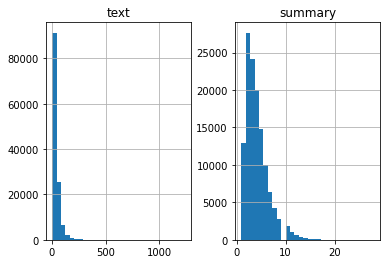

In [410]:
print(df[:10])
df.hist(bins = 30)
plt.show()

#Assigning the Threshold value for Summary and text length and converting it into array

In [412]:
maxText_length=30
maxSummary_length=10

review_clean =np.array(dataset['Clean_Text'])
summary_clean=np.array(dataset['Clean_Summary'])
test_review_clean = np.array(test_own_dataset['Clean_Reviews'])

In [413]:
len(summary_clean)

127428

In [414]:
small_review=[]
small_summary=[]
for i in range(len(review_clean)):
    if(len(summary_clean[i].split())<=maxSummary_length and len(review_clean[i].split())<=maxText_length):
        small_review.append(review_clean[i])
        small_summary.append(summary_clean[i])
        
df_small=pd.DataFrame({'review':small_review,'summary':small_summary})
df_small['summary'] = df_small['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
print(df_small['summary'])

0                             sostok good quality dog food eostok
1                                 sostok not as advertised eostok
2                                    sostok cough medicine eostok
3                                       sostok great taffy eostok
4        sostok great just as good as the expensive brands eostok
                                   ...                           
69904                                    sostok great mint eostok
69905                    sostok great if you have diabetes eostok
69906                              sostok good snack foods eostok
69907                       sostok eclipse spearmint mints eostok
69908                  sostok winterfrost flavor is better eostok
Name: summary, Length: 69909, dtype: object


In [415]:
df_small.shape

(69909, 2)

In [416]:
small_own_reviews=[]
for i in range(len(test_review_clean)):
    if(len(test_review_clean[i].split())<=maxText_length):
        small_own_reviews.append(test_review_clean[i])
    
        
df_test=pd.DataFrame({'Real_time_reviews':small_own_reviews})
print(df_test['Real_time_reviews'])

0    useful review includes enough detail give others feel happened potential customers want know someone else happy want know exactly liked gauge whether aligns preferences compare review dominos
1                                                                                               push light button stays two seconds backlight display keep button depressed light stay till released
2                                                                                                                                                          yes tight get credit cards otherwise good
3                                                                                                      underpants perfect size xxl expected fat afraid buy going perfect good quality price relation
4                                                                               comfortable side make lots lint inside sock tone black lint balls toes take socks besides comfortable warm would buy
5         men m

In [417]:
test_array = df_test.to_numpy()

In [418]:
test_array = np.concatenate(test_array, axis=0 )

In [419]:
test_array

array(['useful review includes enough detail give others feel happened potential customers want know someone else happy want know exactly liked gauge whether aligns preferences compare review dominos',
       'push light button stays two seconds backlight display keep button depressed light stay till released',
       'yes tight get credit cards otherwise good',
       'underpants perfect size xxl expected fat afraid buy going perfect good quality price relation',
       'comfortable side make lots lint inside sock tone black lint balls toes take socks besides comfortable warm would buy',
       'men medium looks like boy size shirt extremely small short compared normal men sizing shirt seems decent quality fit intended gift recipient ordered earlier allow exchange time christmas',
       'purchased black super soft grey faux fur inside new black think lining lining still thinking purchasing choose black awesome',
       'expecting socks thicker least better quality bought white elepha

In [420]:
df_small['review'].shape

(69909,)

In [421]:
test = np.array(df_small['review'])
len(test)

69909

In [422]:
test2 = np.array(df_small['summary'])
len(test2)

69909

#Split the Data into Train and Test

In [423]:
x_train,x_validation,y_train,y_validation = train_test_split(np.array(df_small['review']),np.array(df_small['summary']),test_size=0.1,random_state=0,shuffle=True) 

In [424]:
y_validation.shape

(6991,)

In [425]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_train))
print(x_tokenizer.word_counts.items())

odict_items([('taste', 11255), ('tested', 29), ('friend', 585), ('gave', 750), ('cup', 3295), ('try', 3453), ('really', 6168), ('liked', 896), ('flavor', 9694), ('usually', 896), ('fond', 69), ('flavored', 974), ('coffees', 585), ('skeptical', 116), ('first', 2361), ('glad', 1024), ('tried', 4471), ('interesting', 119), ('strong', 2200), ('product', 11414), ('delicious', 3766), ('coconut', 1095), ('water', 1996), ('many', 2103), ('times', 814), ('could', 2878), ('never', 2076), ('stomach', 424), ('samu', 4), ('transformed', 2), ('though', 1501), ('tasted', 1647), ('great', 16319), ('whether', 122), ('drank', 121), ('whatever', 183), ('else', 716), ('think', 2057), ('blend', 1219), ('done', 261), ('rest', 293), ('sub', 23), ('standard', 163), ('pickles', 40), ('found', 3116), ('dern', 2), ('hots', 11), ('year', 1234), ('ago', 566), ('eaten', 411), ('another', 1017), ('brand', 2020), ('since', 1979), ('absolutely', 1192), ('hands', 250), ('best', 6657), ('pickle', 37), ('perfect', 2696),

In [426]:
test_tokenizer = Tokenizer()
test_tokenizer.fit_on_texts(list(test_array))
print(test_tokenizer.word_counts.items())

odict_items([('useful', 2), ('review', 2), ('includes', 1), ('enough', 1), ('detail', 2), ('give', 1), ('others', 1), ('feel', 1), ('happened', 1), ('potential', 1), ('customers', 1), ('want', 3), ('know', 2), ('someone', 1), ('else', 1), ('happy', 1), ('exactly', 1), ('liked', 1), ('gauge', 1), ('whether', 1), ('aligns', 1), ('preferences', 1), ('compare', 1), ('dominos', 1), ('push', 1), ('light', 2), ('button', 2), ('stays', 1), ('two', 1), ('seconds', 1), ('backlight', 1), ('display', 1), ('keep', 1), ('depressed', 1), ('stay', 1), ('till', 1), ('released', 1), ('yes', 1), ('tight', 1), ('get', 1), ('credit', 1), ('cards', 1), ('otherwise', 1), ('good', 2), ('underpants', 1), ('perfect', 2), ('size', 2), ('xxl', 1), ('expected', 1), ('fat', 1), ('afraid', 1), ('buy', 3), ('going', 1), ('quality', 3), ('price', 1), ('relation', 1), ('comfortable', 2), ('side', 1), ('make', 1), ('lots', 2), ('lint', 2), ('inside', 2), ('sock', 1), ('tone', 1), ('black', 4), ('balls', 1), ('toes', 1),

In [427]:
threshold=4
count=0
total_count=0
frequency=0
total_frequency=0

for key,value in x_tokenizer.word_counts.items():
    total_count+=1
    total_frequency+=value
    if(value<threshold):
        count+=1
        frequency+=value
    
print("% of rare words in vocabulary:",(count/total_count)*100)
print("Total Coverage of rare words:",(freqency/total_frequency)*100)

% of rare words in vocabulary: 66.36301078087624
Total Coverage of rare words: 0.7666924618182263


#Top Most Common Words

In [428]:
x_tokenizer = Tokenizer(num_words=total_count-count) 
x_tokenizer.fit_on_texts(list(x_train))

#Convert text Sequences into Integer Sequences

In [429]:
x_train_sequence    =   x_tokenizer.texts_to_sequences(x_train) 
x_validation_sequence   =   x_tokenizer.texts_to_sequences(x_validation)
test_own_dataset_sequence = test_tokenizer.texts_to_sequences(test_array)
print(len(test_own_dataset_sequence))

9


In [430]:
test = x_tokenizer.texts_to_sequences("My Name is Akshay Kajale and I Love food")

#Padding Zeros upto maximum length

In [431]:
x_train    =   pad_sequences(x_train_sequence,  maxlen=maxText_length, padding='post')
x_validation   =   pad_sequences(x_validation_sequence, maxlen=maxText_length, padding='post')
test_own_data_val =  pad_sequences(test_own_dataset_sequence, maxlen=maxText_length, padding='post')

In [432]:
test_own_data_val.shape

(9, 30)

In [433]:
#size of vocabulary ( +1 for padding token)
x_vocabulary   =  x_tokenizer.num_words + 1
x_vocabulary

10266

In [434]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))
print(y_tokenizer.word_counts.items())

odict_items([('sostok', 62918), ('jamaica', 13), ('me', 364), ('crazy', 81), ('cups', 309), ('flavor', 1324), ('eostok', 62918), ('best', 3645), ('water', 211), ('ever', 1028), ('pickle', 18), ('bits', 19), ('of', 1556), ('deliciousness', 15), ('wonderful', 615), ('product', 2254), ('agree', 20), ('with', 761), ('lucas', 1), ('love', 3151), ('these', 1247), ('great', 8750), ('baby', 229), ('food', 915), ('one', 458), ('my', 2584), ('favorites', 52), ('awful', 135), ('are', 757), ('the', 4640), ('perfect', 612), ('size', 108), ('for', 3394), ('several', 4), ('day', 93), ('santa', 4), ('cruz', 1), ('oatmeal', 83), ('raisen', 1), ('just', 706), ('buy', 520), ('it', 2798), ('bring', 19), ('on', 678), ('heat', 26), ('is', 1986), ('only', 264), ('delicious', 2101), ('bill', 5), ('nice', 639), ('herbal', 46), ('blend', 208), ('difficult', 8), ('to', 1613), ('find', 227), ('kind', 85), ('creamiest', 1), ('espresso', 112), ('variety', 101), ('spice', 105), ('life', 66), ('very', 1742), ('good',

In [438]:
threshold=5
count=0
total_count=0
frequency=0
total_frequency=0

for key,value in y_tokenizer.word_counts.items():
    total_count+=1
    total_frequency+=value
    if(value<threshold):
        count+=1
        frequency+=value
    
print("% of rare words in vocabulary:",(count/total_count)*100)
print("Total Coverage of rare words:",(freqency/total_frequency)*100)

% of rare words in vocabulary: 74.1744358281781
Total Coverage of rare words: 2.6012896801877625


In [439]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=total_count-count) 
y_tokenizer.fit_on_texts(list(y_train))
print(y_tokenizer.word_counts.items())

odict_items([('sostok', 62918), ('jamaica', 13), ('me', 364), ('crazy', 81), ('cups', 309), ('flavor', 1324), ('eostok', 62918), ('best', 3645), ('water', 211), ('ever', 1028), ('pickle', 18), ('bits', 19), ('of', 1556), ('deliciousness', 15), ('wonderful', 615), ('product', 2254), ('agree', 20), ('with', 761), ('lucas', 1), ('love', 3151), ('these', 1247), ('great', 8750), ('baby', 229), ('food', 915), ('one', 458), ('my', 2584), ('favorites', 52), ('awful', 135), ('are', 757), ('the', 4640), ('perfect', 612), ('size', 108), ('for', 3394), ('several', 4), ('day', 93), ('santa', 4), ('cruz', 1), ('oatmeal', 83), ('raisen', 1), ('just', 706), ('buy', 520), ('it', 2798), ('bring', 19), ('on', 678), ('heat', 26), ('is', 1986), ('only', 264), ('delicious', 2101), ('bill', 5), ('nice', 639), ('herbal', 46), ('blend', 208), ('difficult', 8), ('to', 1613), ('find', 227), ('kind', 85), ('creamiest', 1), ('espresso', 112), ('variety', 101), ('spice', 105), ('life', 66), ('very', 1742), ('good',

In [440]:
#convert text sequences into integer sequences
y_train_sequence    =   y_tokenizer.texts_to_sequences(y_train) 
y_validation_sequence   =   y_tokenizer.texts_to_sequences(y_validation) 

In [441]:
#padding zero upto maximum length
y_train    =   pad_sequences(y_train_sequence, maxlen=maxSummary_length, padding='post')
y_validation   =   pad_sequences(y_validation_sequence, maxlen=maxSummary_length, padding='post')

In [442]:
y_vocabulary  =  y_tokenizer.num_words +1
y_vocabulary

2965

#Deleting the Rows containing only Start and end Toekns

In [443]:
y_tokenizer.word_counts['sostok'],len(y_train)   

index=[]
for i in range(len(y_train)):
    cnt=0
    for j in y_train[i]:
        if j!=0:
            count += 1
    if(count==2):
        index.append(i)

y_train=np.delete(y_train,index, axis=0)
x_train=np.delete(x_train,index, axis=0)

print(x_train.shape)
print(y_train.shape)

(62918, 30)
(62918, 10)


In [444]:
index=[]
for i in range(len(y_validation)):
    count=0
    for j in y_validation[i]:
        if j!=0:
            count+=1
    if(count==2):
        index.append(i)

y_validation = np.delete(y_validation,index, axis=0)
x_validation = np.delete(x_validation,index, axis=0)

In [445]:
from keras import backend as K 
K.clear_session()

In [446]:
latent_dimension = 300
embedding_dimension=100

In [447]:
y_validation.shape

(6821, 10)

In [448]:
# Encoder
input_encoder = Input(shape=(maxText_length,))

#embedding layer
embedding_encoder_layer =  Embedding(x_vocabulary, embedding_dimension,trainable=True)(input_encoder)

#encoder lstm 1
lstm_encoder_1 = LSTM(latent_dimension,activation="swish", return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
output_encoder_1, h1, c1 = lstm_encoder_1(embedding_encoder_layer)

#encoder lstm 2
lstm_encoder_2 = LSTM(latent_dimension,activation="swish", return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
output_encoder_2, h2, c2 = lstm_encoder_2(output_encoder_1)

#encoder lstm 3
lstm_encoder_3=LSTM(latent_dimension,activation="swish", return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
output_encoder_3, h3, c3= lstm_encoder_3(output_encoder_2)

#encoder_lstm 4
lstm_encoder_4=LSTM(latent_dimension,activation="swish", return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
output_encoder_final, h, c= lstm_encoder_4(output_encoder_3)

# Set up the decoder, using `encoder_states` as initial state.
input_decoder = Input(shape=(None,))

#embedding layer
embedding_decoder_layer = Embedding(y_vocabulary, embedding_dimension,trainable=True)
embedding_decoder = embedding_decoder_layer(input_decoder)

lstm_decoder = LSTM(latent_dimension, activation="swish", return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
output_decoder,forward_state_decoder, backward_state_decoder = lstm_decoder(embedding_decoder,initial_state=[h, c])

# Attention layer
attention_layer = AttentionLayer(name='attention_layer')
attention_out, attention_states = attention_layer([output_encoder_final, output_decoder])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([output_decoder, attention_out])

#dense layer
dense_decoder_layer =  TimeDistributed(Dense(y_vocabulary, activation='softmax'))
output_decoder = dense_decoder_layer(decoder_concat_input)

# Define the model 
model = Model([input_encoder, input_decoder], output_decoder)

model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      1026600     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 30, 300), (N 721200      lstm[0][0]                       
_______________________________________________________________________________________

In [449]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [450]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [451]:
history=model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=100,callbacks=[es],batch_size=128, validation_data=([x_validation,y_validation[:,:-1]], y_validation.reshape(y_validation.shape[0],y_validation.shape[1], 1)[:,1:]))

Epoch 1/100
492/492 [==============================] - 264s 538ms/step - loss: 2.5856 - val_loss: 2.1960
Epoch 2/100
492/492 [==============================] - 261s 530ms/step - loss: 2.1247 - val_loss: 2.0576
Epoch 3/100
492/492 [==============================] - 264s 537ms/step - loss: 1.9766 - val_loss: 1.9488
Epoch 4/100
492/492 [==============================] - 263s 534ms/step - loss: 1.8811 - val_loss: 1.8955
Epoch 5/100
492/492 [==============================] - 260s 528ms/step - loss: 1.8183 - val_loss: 1.8632
Epoch 6/100
492/492 [==============================] - 260s 528ms/step - loss: 1.7673 - val_loss: 1.8427
Epoch 7/100
492/492 [==============================] - 264s 537ms/step - loss: 1.7200 - val_loss: 1.8140
Epoch 8/100
492/492 [==============================] - 261s 531ms/step - loss: 1.6710 - val_loss: 1.8000
Epoch 9/100
492/492 [==============================] - 265s 538ms/step - loss: 1.6289 - val_loss: 1.7958
Epoch 10/100
492/492 [==============================] -

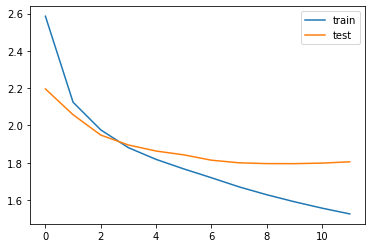

In [452]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [453]:
reverse_target_index=y_tokenizer.index_word
reverse_source_index=x_tokenizer.index_word
target_index=y_tokenizer.word_index

#Inference

In [479]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=input_encoder,outputs=[output_encoder_final, h, c])

# Decoder setup
# Below tensors will hold the states of the previous time step
input_h_decoder = Input(shape=(latent_dimension,))
input_c_decoder = Input(shape=(latent_dimension,))
hidden_state_input = Input(shape=(maxText_length,latent_dimension))

# Get the embeddings of the decoder sequence
embedding_decoder_2= embedding_decoder_layer(input_decoder) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
output_decoder_2, h2, c2 = lstm_decoder(embedding_decoder_2, initial_state=[input_h_decoder, input_c_decoder])

#attention inference
attention_output_inference, attention_states_inference = attention_layer([hidden_state_input, output_decoder_2])
concate_inference_decoder = Concatenate(axis=-1, name='concat')([output_decoder_2, attention_output_inference])

# A dense softmax layer to generate prob dist. over the target vocabulary
output_decoder_2 = dense_decoder_layer(concate_inference_decoder) 

# Final decoder model
decoder_model = Model(
    [input_decoder] + [hidden_state_input,input_h_decoder, input_c_decoder],
    [output_decoder_2] + [h2,c2])


In [480]:
def decodeInput(input):
    stopping_criteria = False
    text_sentence = ''
    # Encode the input as state vectors.
    encoder_output, encoder_h, encoder_c = encoder_model.predict(input)
    # Generate empty target sequence of length 1.
    target_sequence = np.zeros((1,1))
    # Populate the first word of target sequence with the start word.
    target_sequence[0, 0] = target_index['sostok']

    while not stopping_criteria:
      
        output, hidden, context = decoder_model.predict([target_sequence] + [encoder_output, encoder_h, encoder_c])
        # Sample a token
        token_index = np.argmax(output[0, -1, :])
        token = reverse_target_index[token_index]

        # Exit condition: either hit max length or find stop word.
        if (token == 'eostok'  or len(text_sentence.split()) >= (maxSummary_length-1)):
            stopping_criteria = True
        
        if(token!='eostok'):
            text_sentence += ' '+token
        
        # Update the target sequence (of length 1).
        target_sequence = np.zeros((1,1))
        target_sequence[0, 0] = token_index

        # Update internal states
        encoder_h, encoder_c = hidden, context

    return text_sentence

In [481]:
def inputTosummary(input):
    summary=''
    for i in input:
        if((i!=0 and i!=target_index['sostok']) and i!=target_index['eostok']):
            summary=summary+reverse_target_index[i]+' '
    return summary

def inputToText(input):
    text=''
    for i in input:
        if(i!=0):
            text=text+reverse_source_index[i]+' '
    return text

In [482]:
given_summaries = []
predicted_summaries = []
for i in range(0,100):
    print("Review:",inputToText(x_validation[i]))
    given_summaries.append(inputTosummary(y_validation[i]))
    print("Original summary:",given_summaries[i])
    predicted_summaries.append(decodeInput(x_validation[i].reshape(1,maxText_length)))
    print("Predicted summary:",predicted_summaries[i])
    print("\n")

Review: thought great want hot one word item great 
Original summary: powder 
Predicted summary:  great product


Review: variety pack popchips sooo good flavors delicious way healthier regular greasy potato chips popchips half fat calories def must buy 
Original summary: popchips good 
Predicted summary:  great snack


Review: almond flour fabulous fine without brands flavor world ordered two pack twice four boxes making tiny cheesecakes blueberry muffins pancakes mm 
Original summary: love it 
Predicted summary:  great product


Review: happy bought set rather individual items great deal guys cant wait great specials 
Original summary: super savings 
Predicted summary:  great product


Review: jet fuel may best bold coffees maybe could consider packing cup lots jet fuel 
Original summary: jet fuel 
Predicted summary:  great coffee


Review: things best idea ever sugar free cosmo never could carry little packets around one anywhere vodka water taste awesome 
Original summary: awesome 

In [ ]:
model.predict([x_validation,y_validation[:,:-1]], verbose = 0)

In [484]:
for i in range(0,8):
    print("Summary:",decodeInput(test_own_data_val[i].reshape(1,maxText_length)))
    print("\n")

Summary:  great product


Summary:  great tea


Summary:  great product


Summary:  great for training


Summary:  great


Summary:  great product


Summary:  great


Summary:  great product




In [485]:
test_own_data_val.shape

(9, 30)

In [486]:
from nltk.translate.bleu_score import corpus_bleu

In [487]:
x_train.shape

(62918, 30)

In [488]:
score = corpus_bleu(given_summaries,predicted_summaries)
print(score)

0.8182026330417821


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
